# Endava support tickets classification with fastai

In [1]:
from pathlib import Path
import pandas as pd
from fastai.text import *
from sklearn.metrics import classification_report
import matplotlib.cm as cm
# import pandas_profiling

### Explore dataset

In [2]:
datapath = Path("data/Endava") #'~/projects/data/Endava'
bs = 48
datapath

PosixPath('data/Endava')

In [3]:
all_data = pd.read_csv(datapath / 'all_tickets.csv')

#all_data.describe().transpose())
#all_data.profile_report()

print(all_data.info())
print(all_data['category'].value_counts())

# Check if dataframe contains NaN
print(all_data.isna().any())
# all_data.loc[all_data['title'].isna()]#.index

all_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48549 entries, 0 to 48548
Data columns (total 9 columns):
title               47837 non-null object
body                48549 non-null object
ticket_type         48549 non-null int64
category            48549 non-null int64
sub_category1       48549 non-null int64
sub_category2       48549 non-null int64
business_service    48549 non-null int64
urgency             48549 non-null int64
impact              48549 non-null int64
dtypes: int64(7), object(2)
memory usage: 3.3+ MB
None
4     34061
5      9634
6      2628
7       921
11      612
8       239
9       191
3       137
1        72
12       45
0         4
2         3
10        2
Name: category, dtype: int64
title                True
body                False
ticket_type         False
category            False
sub_category1       False
sub_category2       False
business_service    False
urgency             False
impact              False
dtype: bool


,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


### Data preprocessing

In [4]:
# Prepare train and test set 
def preprocess(string): # not used
    """Input: String. Output: Simplified sting (lowercase, no special characters, ...)."""
    string = string.lower()
    string = re.sub("[(\xa0)(\n)]", " ", string) # replace non-breaking space and newline
    string = re.sub("\W+", " ", string) # replace any non-alphanumeric character
    string = re.sub("\d+", "0", string) # replace all digits with 0
    string = re.sub(" +", " ", string) # replace multiple spaces
    return string

# Remove rows containing NaN
def replace_nan(df):
    new_row = []
    for row in df.itertuples():
        if pd.isna(row.title):
            new_row.append('')
        else:
            new_row.append(row.title)
    return new_row

train = pd.read_csv(datapath / 'train.csv')
train['title'] = replace_nan(train)
train_df = pd.DataFrame({"Category": train['category'], "Text": train['title'] + train['body']})
train_df['Validation'] = False

test = pd.read_csv(datapath / 'test.csv')
test['title'] = replace_nan(test)
test_df = pd.DataFrame({"Category": test['category'], "Text": test['title'] + test['body']})
test_df['Validation'] = True

full_df = pd.concat([train_df, test_df], ignore_index=True)

print(full_df.info())
full_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48540 entries, 0 to 48539
Data columns (total 3 columns):
Category      48540 non-null int64
Text          48540 non-null object
Validation    48540 non-null bool
dtypes: bool(1), int64(1), object(1)
memory usage: 806.0+ KB
None


,Category,Text,Validation
0,4,new starter bucharestwednesday pm re va ne si ...,False
1,4,log on to oracle for the timelog hi please ris...,False
2,5,new purchase popurchase po dear purchased cs s...,False
3,4,add this type of notifications the possible ro...,False
4,4,passwordwednesday pm hi engineer coming tomorr...,False


## Fine-tune pretrained language model

In [5]:
# Language model data
data_lm = (TextList.from_df(full_df, cols='Text')
            .split_from_df(col='Validation')
            .label_for_lm() # .label_from_df(cols=0)
            .databunch(bs=bs))

# data_lm = TextLMDataBunch.from_df(datapath, train_df, test_df)
data_lm.show_batch()

idx,text
0,xxunk march logged has resolved hello please sr snow add type possible root cause thank leader ext thursday march logged has resolved hello please advised assigned queue has resolved summary issues reported by added date resolution details mailbox databases after which re activated mailbox databases back per activation preference number resolver resolution date kind regards ext ref msg xxbos passwordwednesday pm hi engineer coming tomorrow replace faulty controller replacement controller
1,attached form please fill two separate forms back kind regards analyst ext hub thursday split client others hi moment client others thing these separate customers separate budget forecast track separately come back different help splitting others customers thank xxbos reset xxunk inform he returned annual leave can not remember his xxbos link to maps leaver formtuesday july link maps leaver form hello please link maps placed leaver form easier thank
2,comes but once year thank you for joining bringing cheer fun was for mystery year event we you had great experience celebrating together enjoying xxunk moments even though party over memories laughter still xxunk you can get glimpse moments by checking out pictures here feedback survey we continuously looking improve make you enjoy our future events much possible we would highly appreciate your feedback regarding party let know your opinion
3,old afterwards old become two weeks means unable change upload files download moment finally after date proceed closing down kindly note deadline site file transfer october enjoy browsing looking forward thank kind regards ext hub xxbos accountwednesday february pm hello started work intern board thank xxbos device alert notification printer alert tray has a problem xxunk printer tray has problem printer details malfunction tray tray copier details malfunction tray tray
4,confusion task backlog regarding issue story discipline links please help priority issue affecting more please assign right assume issue ad location level please investigation location right named persons also please make reproduces more different locations thank forward tuesday pm re hello please let log understand issue backlog advised by can not intervene further than logging issue please let assist further thank analyst community builder ext hub tuesday pm re seems


In [6]:
# Load/save databunch
data_lm.save('data_lm.pkl')
# data_lm = load_data('data_lm.pkl', bs=bs)

In [7]:
# Pretrained model based on wikitext-103 dataset
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


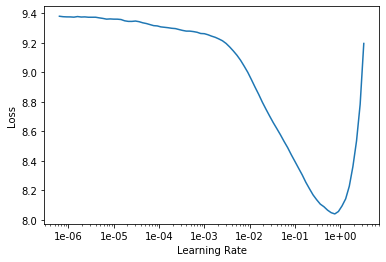

In [8]:
learn.lr_find()
learn.recorder.plot(skip_end=5)

epoch,train_loss,valid_loss,accuracy,time
0,4.705749,4.484204,0.269785,03:15


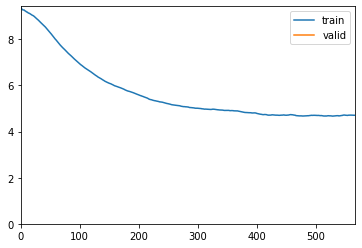

In [9]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

In [10]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,4.178486,4.157518,0.307795,03:55
1,3.850792,3.890441,0.344539,03:58
2,3.638028,3.723919,0.367153,03:55
3,3.349169,3.638151,0.379998,03:51
4,3.115800,3.599051,0.388955,03:50
5,2.947399,3.601882,0.392177,03:47
6,2.851526,3.611149,0.392569,03:54


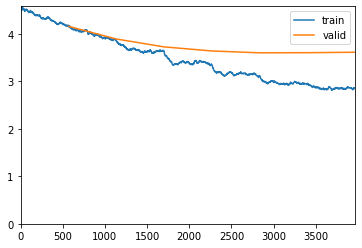

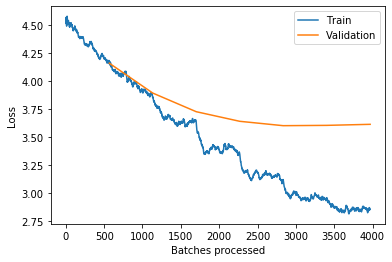

In [11]:
learn.fit_one_cycle(7, 1e-3, moms=(0.8,0.7))

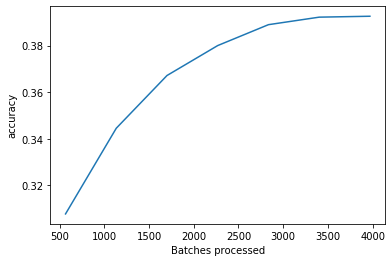

In [12]:
# learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [13]:
learn.save('model_lm')
# learn.load('model_lm')

In [14]:
# Test model
learn.predict("Hi my password is expired and", n_words=25, temperature=0.75)

'Hi my password is expired and can not access could you please help with asap thanks sent monday october re with hello still have before could you please direct thank you'

In [15]:
# Save encoder from model
learn.save_encoder('fine_tuned_enc')

## Classifier

In [16]:
# Classifier model data
data_clas = (TextList.from_df(full_df, cols='Text', vocab=data_lm.vocab)
             .split_from_df(col='Validation')
             .label_from_df(cols='Category')
             .databunch(bs=bs))

# data_clas = TextClasDataBunch.from_df(train_df, test_df, vocab=data_lm.vocab, bs=bs)

data_clas.show_batch()

text,target
xxbos complete xxunk complete tab please hi ll have look come back you please log ticket for assign thank you best regards administrator sent monday july fwd complete tab please hi can someone please check out access unable amend tab regards change control one canada square canary wharf change control forwarded message date july re complete tab please hi was previously able complete changes what happened be grateful if you,4
xxbos ad memberships audit delete users from groupssent tuesday ad memberships delete users groups importance high hi please treat request incident requiring urgent attention please remove list users below groups lists whose names begin either or complete list such groups attached but by you start process number these groups have themselves already deleted you find some below list users any groups by you get process them appreciate large list users,4
xxbos confluence user accesssent monday october release sprint demo hi please action below thank you manager mobile next vacations th sent monday october re release sprint demo hi unfortunately one users have locked generic confluence i d again instructing them try after unsuccessful attempts can you please reset generic i d confirm test manager testing centre excellence st court chart way west rh sent october re release sprint demo hi,4
xxbos rejected timecardjuly pm urgent july annual leaves dear please assist issue thank july pm urgent july annual leaves hi please help resolve thanks july urgent july annual leaves dear dear heard testers experiencing certain issues today by persons cards pending date code name task name type location country card status test testing cost regular rejected test testing cost regular rejected test testing cost regular rejected test testing cost regular,4
xxbos xxunk hi guys please help out providing possible he working client immediate thanks leader november pm re troubleshooting can not good added november pm re troubleshooting hi log log ad then problem thanks leader november pm re troubleshooting hi thank clarifying picker choose provides error let feedback thanks november pm re troubleshooting hi please regarding think accept invitation must getting option sign organizational personal please organizational please note create,5


In [17]:
# Load/save databunch
data_clas.save('data_clas.pkl')
# data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [18]:
data_clas.classes

[1, 3, 4, 5, 6, 7, 8, 9, 11, 12]

In [19]:
learn_cl = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, callback_fns=ShowGraph)
                               #metrics=[accuracy, Precision(), Recall(), FBeta(beta=1, average='micro')])
learn_cl.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (43686 items)
x: TextList
xxbos new starter bucharestwednesday pm re va ne si va la,xxbos log on to oracle for the xxunk hi please rise assign thank best regards log hi please help having difficulties getting platform senior mob,xxbos new purchase popurchase po dear purchased cs stand alone wireless presentation meeting rooms link please log allocation please help device kind regards administrator,xxbos add this type of notifications the possible root cause xxunk march logged has resolved hello please sr snow add type possible root cause thank leader ext thursday march logged has resolved hello please advised assigned queue has resolved summary issues reported by added date resolution details mailbox databases after which re activated mailbox databases back per activation preference number resolver resolution date kind regards ext ref msg,xxbos passwordwednesday pm hi engineer coming tomorrow replace faulty controller replacement con

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


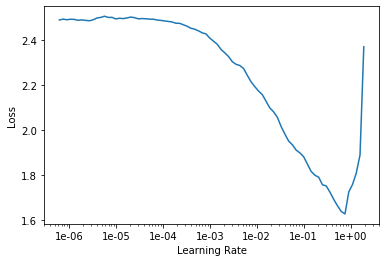

In [20]:
learn_cl.lr_find()
learn_cl.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.503952,0.413293,0.865472,01:56


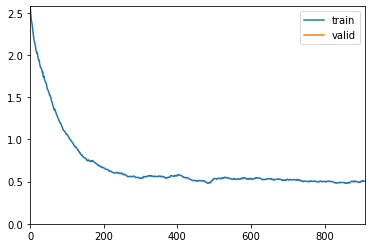

In [21]:
learn_cl.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.365959,0.355735,0.882571,03:40
1,0.310232,0.351204,0.886073,03:37


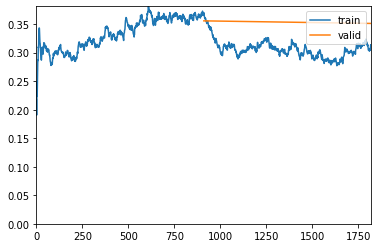

In [57]:
learn_cl.freeze_to(-3)
learn_cl.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.336824,0.369544,0.874330,03:28
1,0.275129,0.352639,0.887103,04:00


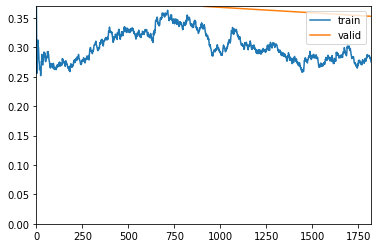

In [55]:
learn_cl.freeze_to(-3)
learn_cl.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.313327,0.344761,0.886485,05:11
1,0.312326,0.340304,0.887927,05:21


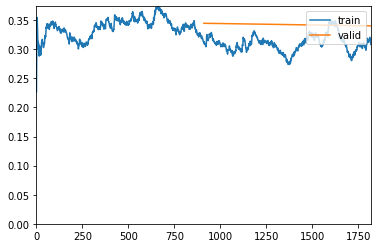

In [23]:
learn_cl.unfreeze()
learn_cl.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
#learn_cl.freeze()

In [56]:
# Lead/save model
learn_cl.save('model_cl') #first_cl.pth
#learn_cl.load('model_cl')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (43686 items)
x: TextList
xxbos new starter bucharestwednesday pm re va ne si va la,xxbos log on to oracle for the xxunk hi please rise assign thank best regards log hi please help having difficulties getting platform senior mob,xxbos new purchase popurchase po dear purchased cs stand alone wireless presentation meeting rooms link please log allocation please help device kind regards administrator,xxbos add this type of notifications the possible root cause xxunk march logged has resolved hello please sr snow add type possible root cause thank leader ext thursday march logged has resolved hello please advised assigned queue has resolved summary issues reported by added date resolution details mailbox databases after which re activated mailbox databases back per activation preference number resolver resolution date kind regards ext ref msg,xxbos passwordwednesday pm hi engineer coming tomorrow replace faulty controller replacement con

### Check model

In [25]:
learn_cl.predict("hello we noticed doors open require card be swiped") # category 11

(Category 11,
 tensor(8),
 tensor([3.7321e-04, 1.1352e-04, 2.4197e-01, 2.4952e-02, 3.2622e-02, 1.7472e-01,
         9.2528e-04, 2.3851e-05, 5.2427e-01, 2.9317e-05]))

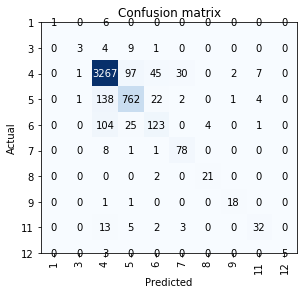

In [26]:
interp = ClassificationInterpretation.from_learner(learn_cl)
interp.plot_confusion_matrix(title='Confusion matrix')

In [35]:
# Classification report
# classification_report(test_labels, predicted, target_names=np.unique(test_labels))
results = learn_cl.show_results()
results

text,target,prediction
xxbos not workingsent friday working good morning trying connect via but working please log below built enter password socket listening need hold release interface waiting client connected log hold off hold release warning server certificate verification method enabled for more info note current script setting allow configuration call defined scripts socket buffers resolve attempting establish connection with connect connection established with client link client link remote wait initial packet warning,5,4
xxbos issues with outlook and ad profilesent friday for extension assigned hi please raise for below queue thanks senior engineer sent friday re for extension assigned thank you you can handle remotely would prefer have delivered by post case thank you for sent re for extension assigned hi can prepare for you laptop during frankfurt order setup your you have using your credentials while laptop connected having said we have,4,9
xxbos user guidance service now xxunk december pm nj phone lines connecting please log topic about user guidance interface please assign best regards consultant friday december pm re nj phone lines connecting chrome latest safari thanks senior engineer ext date friday december re nj phone lines connecting hi looking image incompatibility view issue please version safari browser safari versions fully supported by were chrome browser where impersonated please chrome waiting,4,4
xxbos and from xxunk hi assist change regards friday november machine ca forward la la thursday november pm swift re machine hi suggest traffic routed example were second add traffic shows think guys add kind regards november re machine hi tracing route over maximum hops timed out timed out timed out timed out timed out thanks thursday november pm re machine hi thank result instead kind regards november machine tracing,4,4
xxbos make xxunk december re update migration issue hello please make location editable kind regards discipline lead thursday december re update migration issue importance high hi looking please make available again until manage transfer information site thank mobile next vacations rd thursday december re update migration issue hello received asking considered invoicing believe links must editable mode please let great discipline lead wednesday december pm re update migration issue importance,4,4


In [37]:
predictions = learn_cl.get_preds()
predictions

[tensor([[1.3023e-03, 1.4012e-03, 7.1287e-01,  ..., 1.2970e-04, 7.2132e-04,
          2.0378e-05],
         [3.7986e-03, 2.0576e-02, 3.7461e-01,  ..., 4.6040e-01, 1.4550e-03,
          5.1098e-04],
         [4.4477e-03, 1.4833e-03, 7.8909e-01,  ..., 3.2302e-04, 1.0008e-03,
          1.2457e-03],
         ...,
         [2.0512e-02, 6.1521e-02, 5.0022e-01,  ..., 1.6715e-02, 2.0030e-02,
          2.5243e-03],
         [9.0858e-03, 2.2696e-02, 7.3161e-01,  ..., 5.1529e-04, 9.1526e-03,
          1.5315e-04],
         [1.9831e-02, 5.8653e-02, 5.0291e-01,  ..., 6.4498e-03, 1.1451e-02,
          2.2106e-03]]), tensor([3, 2, 2,  ..., 2, 1, 3])]

In [47]:
validation = learn_cl.validate(metrics=[accuracy, Precision(), Recall(), FBeta(beta=1, average='micro')])
validation

/home/ubuntu/anaconda3/lib/python3.6/site-packages/fastai/metrics.py:189: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


[0.3403043, tensor(0.8879), tensor(0.8111), tensor(0.6471), tensor(0.8879)]

In [54]:
learn_cl.validate(metrics=[accuracy, Precision(), Recall(), FBeta(beta=1, average='micro')])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/fastai/metrics.py:189: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


[0.3392543, tensor(0.8879), tensor(0.7837), tensor(0.6698), tensor(0.8879)]

In [29]:
# Model interpretation with attention
txt_ci = TextClassificationInterpretation.from_learner(learn_cl)
test_text = "I lost the password to my laptop"
txt_ci.show_intrinsic_attention(test_text,cmap=cm.Purples)

/opt/conda/conda-bld/pytorch_1565272279342/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272279342/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272279342/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272279342/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
